In [1]:
!pip3 install torch_geometric

In [2]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
import torch_geometric
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from google.colab import drive

pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_columns", None)
pd.set_option("display.min_rows", 50)
pd.set_option("display.max_rows", 50)
pd.set_option("display.width", None)

drive_path = "/content/drive"
drive.mount(drive_path)
data_path = f"{drive_path}/My Drive/Colab Notebooks/gnn/input/march-machine-learning-mania-2025"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
sea = pd.read_csv(f"{data_path}/MSeasons.csv", usecols=["Season", "DayZero"])
sea["DayZero"] = pd.to_datetime(sea["DayZero"])
print(f"sea {sea.shape}")
print(sea)
print()
sea.info()

sea (41, 2)
    Season    DayZero
0     1985 1984-10-29
1     1986 1985-10-28
2     1987 1986-10-27
3     1988 1987-11-02
4     1989 1988-10-31
5     1990 1989-10-30
6     1991 1990-10-29
7     1992 1991-11-04
8     1993 1992-11-02
9     1994 1993-11-01
10    1995 1994-10-31
11    1996 1995-10-30
12    1997 1996-10-28
13    1998 1997-10-27
14    1999 1998-10-26
15    2000 1999-11-01
16    2001 2000-10-30
17    2002 2001-10-29
18    2003 2002-11-04
19    2004 2003-11-03
20    2005 2004-11-01
21    2006 2005-10-31
22    2007 2006-10-30
23    2008 2007-11-05
24    2009 2008-11-03
25    2010 2009-11-02
26    2011 2010-11-01
27    2012 2011-10-31
28    2013 2012-11-05
29    2014 2013-11-04
30    2015 2014-11-03
31    2016 2015-11-02
32    2017 2016-10-31
33    2018 2017-10-30
34    2019 2018-11-05
35    2020 2019-11-04
36    2021 2020-11-02
37    2022 2021-11-01
38    2023 2022-10-31
39    2024 2023-11-06
40    2025 2024-11-04

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0

In [4]:
tea = pd.read_csv(f"{data_path}/MTeams.csv", usecols=["TeamID", "TeamName"])
print(f"tea {tea.shape}")
print(tea)

tea (380, 2)
     TeamID          TeamName
0      1101       Abilene Chr
1      1102         Air Force
2      1103             Akron
3      1104           Alabama
4      1105       Alabama A&M
5      1106        Alabama St
6      1107       SUNY Albany
7      1108         Alcorn St
8      1109      Alliant Intl
9      1110     American Univ
10     1111    Appalachian St
11     1112           Arizona
12     1113        Arizona St
13     1114   Ark Little Rock
14     1115    Ark Pine Bluff
15     1116          Arkansas
16     1117       Arkansas St
17     1118      Armstrong St
18     1119              Army
19     1120            Auburn
20     1121           Augusta
21     1122       Austin Peay
22     1123           Ball St
23     1124            Baylor
24     1125           Belmont
..      ...               ...
355    1456    William & Mary
356    1457          Winthrop
357    1458         Wisconsin
358    1459           Wofford
359    1460         Wright St
360    1461           Wyomi

In [5]:
res = pd.DataFrame()

for type_ in ["RegularSeason", "NCAATourney"]:
  res = pd.concat([res, pd.read_csv(f"{data_path}/M{type_}DetailedResults.csv")])

res = res.reset_index(drop=True)

res.insert(0, "WID", res["Season"].astype(str) + "_" + res["DayNum"].astype(str).str.zfill(3) + "_" + res["WTeamID"].astype(str) + "_" + res["LTeamID"].astype(str))
res.loc[res["WTeamID"] < res["LTeamID"], "WID"] = res["Season"].astype(str) + "_" + res["DayNum"].astype(str).str.zfill(3) + "_" + res["LTeamID"].astype(str) + "_" + res["WTeamID"].astype(str)
res.insert(1, "LID", res["WID"])

res.insert(2, "WSeason", res.pop("Season"))
res.insert(3, "LSeason", res["WSeason"])

res.insert(4, "WDayNum", res.pop("DayNum"))
res.insert(5, "LDayNum", res["WDayNum"])

res.insert(7, "LTeamID", res.pop("LTeamID"))

res.insert(8, "WOppID", res["LTeamID"])
res.insert(9, "LOppID", res["WTeamID"])

res.insert(10, "WMargin", res["WScore"] - res["LScore"])
res.insert(11, "LMargin", -res["WMargin"])

res.insert(12, "WLoc", res.pop("WLoc").map({"A": -1, "N": 0, "H": 1}))
res.insert(13, "LLoc", -res["WLoc"])

res.insert(14, "WNumOT", res.pop("NumOT"))
res.insert(15, "LNumOT", res["WNumOT"])

res = pd.concat([
    res[[c for c in res if c[0] == "W"]].rename(columns={c: c[1:] for c in res if c[0] == "W"}),
    res[[c for c in res if c[0] == "L"]].rename(columns={c: c[1:] for c in res if c[0] == "L"}),
]).sort_values("ID").reset_index(drop=True)

for c in res.loc[:, "Season":"OppID"]:
  res[c] = res[c].astype("int32")

sy = StandardScaler()
cy = "Margin"
res[cy] = sy.fit_transform(res[[cy]]).astype("float32")

cf = "Loc"
for c in res.loc[:, cf:]:
  res[c] = res[c].astype("float32")

res.loc[:, cf:] = StandardScaler().fit_transform(res.loc[:, cf:])

res = pd.merge(res, sea, on="Season")
res.insert(1, "Date", res['DayZero'] + pd.to_timedelta(res["DayNum"], unit="D"))
res = res.drop(columns=["Season", "DayZero", "DayNum"])

res = pd.merge(res, tea, on="TeamID")
res = pd.merge(res, tea, left_on="OppID", right_on="TeamID", suffixes=["", "_"]).rename(columns={"TeamName_": "OppName"})
res.insert(4, "TeamName", res.pop("TeamName"))
res.insert(5, "OppName", res.pop("OppName"))

print(f"res {res.shape}")
print(res)
print()
res.info()

res (240528, 24)
                        ID       Date  TeamID  OppID        TeamName         OppName    Margin       Loc     NumOT     Score       FGM       FGA      FGM3      FGA3       FTM       FTA        OR        DR       Ast        TO       Stl       Blk        PF  TeamID_
0       2003_010_1328_1104 2002-11-14    1104   1328         Alabama        Oklahoma  0.397053  0.000000 -0.225257 -0.153137  0.490802  0.226886 -1.252690 -0.951573 -0.476284 -0.233940  0.862797  0.073893 -0.012935  2.304793  0.173707 -1.023865  0.846855     1328
1       2003_010_1328_1104 2002-11-14    1328   1104        Oklahoma         Alabama -0.397053  0.000000 -0.225257 -0.634959 -0.537384 -0.438796 -1.583592 -1.611310  0.346381  0.273258 -0.095526 -0.317623 -1.148182  1.129768  0.848504 -0.583745  0.399831     1104
2       2003_010_1393_1272 2002-11-14    1393   1272        Syracuse         Memphis -0.463229  0.000000 -0.225257 -0.554655 -0.126110  1.425113 -0.259983  0.697769 -0.805351  0.019659  2.300

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
tensor_kwargs = dict(dtype=torch.float32, device=device)
x = torch.tensor(res.loc[:, "Loc":].values, **tensor_kwargs)
print(f"x {x.shape}")
print(x)

x torch.Size([240528, 17])
tensor([[ 0.0000e+00, -2.2526e-01, -1.5314e-01,  ..., -1.0239e+00,
          8.4685e-01,  1.3280e+03],
        [ 0.0000e+00, -2.2526e-01, -6.3496e-01,  ..., -5.8375e-01,
          3.9983e-01,  1.1040e+03],
        [ 0.0000e+00, -2.2526e-01, -5.5466e-01,  ...,  1.1767e+00,
         -4.9422e-01,  1.2720e+03],
        ...,
        [ 0.0000e+00, -2.2526e-01, -8.7587e-01,  ..., -5.8375e-01,
         -4.9422e-01,  1.4580e+03],
        [ 0.0000e+00, -2.2526e-01,  1.6135e+00,  ..., -1.4640e+00,
         -2.7071e-01,  1.1650e+03],
        [ 0.0000e+00, -2.2526e-01,  1.1317e+00,  ..., -5.8375e-01,
         -4.9422e-01,  1.4630e+03]])


In [15]:
# Get team-date index mapping
team_date_idx = dict(zip(zip(res['TeamID'], res['Date']), range(len(res))))

# Create unidirectional temporal edges (later game -> earlier game)
df_team_time = res[['TeamID', 'Date']].sort_values(['TeamID', 'Date'])
df_team_time['curr_idx'] = df_team_time.index
df_team_time['prev_idx'] = df_team_time.groupby('TeamID')['curr_idx'].shift(1)  # Previous game
df_team_time['next_idx'] = df_team_time.groupby('TeamID')['curr_idx'].shift(-1)  # Next game

# Create temporal edges (from current to previous AND from next to current)
temporal_edges_prev = df_team_time.dropna(subset=['prev_idx'])[['curr_idx', 'prev_idx']].values.astype(int)
temporal_edges_next = df_team_time.dropna(subset=['next_idx'])[['next_idx', 'curr_idx']].values.astype(int)
temporal_edges = np.vstack([temporal_edges_prev, temporal_edges_next])

# Create bidirectional game edges
game_edges = []
for nodes in game_to_nodes.values():
    if len(nodes) == 2:
        game_edges.extend([(nodes[0], nodes[1]), (nodes[1], nodes[0])])

# Combine all edges and create edge attributes
game_edges = np.array(game_edges)
edge_index = torch.tensor(np.vstack([temporal_edges, game_edges]).T, **tensor_kwargs)
edge_attr = torch.cat([
    torch.zeros(len(temporal_edges), 1, **tensor_kwargs),
    torch.ones(len(game_edges), 1, **tensor_kwargs)
], dim=0)

# Add time feature from Date
time = torch.tensor((res['Date'] - res['Date'].min()).dt.total_seconds().values, **tensor_kwargs).unsqueeze(1)

# Create kwargs with ID, TeamID, and OppID
kwargs = {
    'id_lookup': res['ID'].tolist(),  # Keep as list for indexing
    'team_id': torch.tensor(res['TeamID'].values, dtype=torch.int32),  # Keep as tensor
    'opp_id': torch.tensor(res['OppID'].values, dtype=torch.int32),  # Keep as tensor
    'res_df': res  # Store reference to original DataFrame
}

# Create final Data object
y = torch.tensor(res['Margin'].values, **tensor_kwargs).unsqueeze(1)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, time=time, **kwargs)

# Print number of nodes
print(f"Number of nodes: {data.num_nodes}")

# Print number of edges
print(f"Number of edges: {data.num_edges}")

# Print shape of each attribute
print(f"x shape: {data.x.shape}")
print(f"edge_index shape: {data.edge_index.shape}")
print(f"edge_attr shape: {data.edge_attr.shape}")
print(f"y shape: {data.y.shape}")
print(f"time shape: {data.time.shape}")

# Print other properties
print(f"All keys: {data.keys()}")

Number of nodes: 240528
Number of edges: 720842
x shape: torch.Size([240528, 17])
edge_index shape: torch.Size([2, 720842])
edge_attr shape: torch.Size([720842, 1])
y shape: torch.Size([240528, 1])
time shape: torch.Size([240528, 1])
All keys: ['id_lookup', 'edge_index', 'edge_attr', 'team_id', 'res_df', 'y', 'opp_id', 'time', 'x']


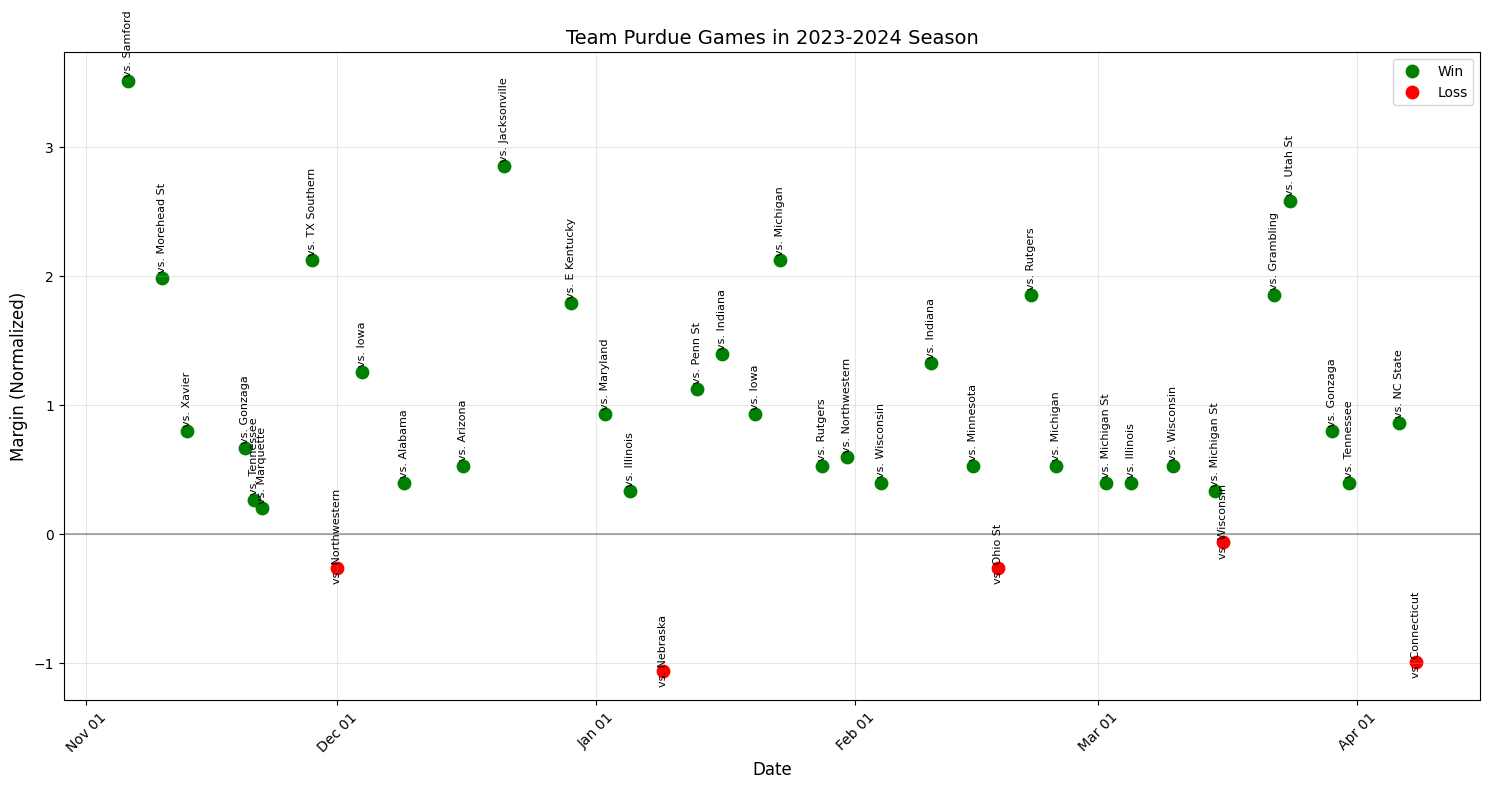

In [17]:
def visualize_team_season(data, team_id=1345, season_year=2024):
    # Get tensor data
    team_ids = data.team_id.cpu().numpy()
    times = data.time.cpu().numpy().flatten()

    # Create index lookup
    indices = np.where(team_ids == team_id)[0]

    # Use these indices to get data from original DataFrame
    team_games = data.res_df.iloc[indices].copy()

    # Continue with date filtering and visualization
    season_start = datetime(season_year-1, 11, 1)
    season_end = datetime(season_year, 4, 30)
    team_games = team_games[(team_games['Date'] >= season_start) &
                            (team_games['Date'] <= season_end)]

    # Sort by date
    team_games = team_games.sort_values('Date')

    team_name = team_games['TeamName'].iloc[0]

    if len(team_games) == 0:
        return None, f"No games found for {team_name} in {season_year-1}-{season_year} season"

    # Unnormalize margins if needed (using inverse_transform)
    # team_games['Margin'] = sy.inverse_transform(team_games[['Margin']])

    # Plot
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot margins
    wins = team_games['Margin'] > 0
    losses = ~wins

    ax.scatter(team_games.loc[wins, 'Date'], team_games.loc[wins, 'Margin'],
               color='green', s=80, label='Win')
    ax.scatter(team_games.loc[losses, 'Date'], team_games.loc[losses, 'Margin'],
               color='red', s=80, label='Loss')

    # Add horizontal line at margin=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Format plot
    ax.set_title(f'Team {team_name} Games in {season_year-1}-{season_year} Season', fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Margin (Normalized)', fontsize=12)

    # Format dates on x-axis
    date_fmt = mdates.DateFormatter('%b %d')
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)

    # Annotate with opponent names but limit text length
    for _, game in team_games.iterrows():
        # Truncate opponent name if too long
        opp_name = game['OppName']
        if len(opp_name) > 12:
            opp_name = opp_name[:10] + '..'

        # Position annotation based on margin
        y_offset = 5 if game['Margin'] > 0 else -10

        ax.annotate(f"vs. {opp_name}",
                   (game['Date'], game['Margin']),
                   xytext=(0, y_offset),
                   textcoords='offset points',
                   ha='center', fontsize=8,
                   rotation=90)

    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return fig, f"Created visualization for {team_name} in {season_year-1}-{season_year} season"

# Call the function with Purdue's team ID
team_id = 1345  # Purdue
fig, msg = visualize_team_season(data, team_id=team_id, season_year=2024)
plt.show()